In [401]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from training_utils import add_vars


# MLP Scaling on Repeated MNIST Data

### Experimental Design

#### MLP Models

I train 24 MLP models of varying sizes. All models have two hidden layers and approximately the same ratio between the dimensions of the two hidden layers. The models trained for 32 epochs on an unmodified MNIST dataset and were evaluated about 5 times per epoch on the MNIST test set. 

##### Small Details
* The starting learning rate was 0.05 for the smallest model. For larger models, the starting lr was $\frac{0.05}{\sqrt{size}}$, where $size$ is the size of the model relative to the smallest model.
  *  A model 4 times the size of the smallest model, for example, started with a learning rate of .025. 
* I reduced the learning rate by a factor of 10 if evaluation performance plateaued for an epoch of training.
* I used the Adam optimizer with PyTorch's default parameters (ignoring the learning rate)
* I use dropout on both hidden layers (probability .3)

#### CNN Models

I train 9 CNN models of varying sizes. All models have two Conv layers, two MLP layer, and approximately the same ratios between the dimensions of their layers. The models trained for 32 epochs on an unmodified MNIST dataset and were evaluated about 5 times per epoch on the MNIST test set. 

##### Small Details
* The starting learning rate was 0.05 for the smallest model. For larger models, the starting lr was $\frac{0.05}{\sqrt{size}}$, where $size$ is the size of the model relative to the smallest model.
  *  A model 4 times the size of the smallest model, for example, started with a learning rate of .025. 
* I did not use an learning rate schedule.
* I used the Adam optimizer with PyTorch's default parameters (ignoring the learning rate)
* I use dropout on both hidden layers (probability .3)

### Results

Figure 1 visualizes the performance of the models on the training set and the test set throughout their training periods. The top row plots performance against relative compute, and the bottom row plots performance against the number of gradient updates. "eval ewm" signifies the exponentially weighted moving average of the lowest score that the model has achieved by that point in its training. The values plotted in figure 1 are the average of 5 training runs.

In [402]:
lin_df = pd.read_csv('MNIST_linear.csv')
CNN_df = pd.read_csv('MNIST_CNN.csv')

lin_avg_df = lin_df.groupby(['model_size', 'step']).mean()
CNN_avg_df = CNN_df.groupby(['model_size', 'step']).mean()

lin_avg_df['eval ewm'] = lin_avg_df.groupby('model_size')['eval_min'].transform(lambda x: x.ewm(com=2).mean()).values
CNN_avg_df['eval ewm'] = CNN_avg_df.groupby('model_size')['eval_min'].transform(lambda x: x.ewm(com=2).mean()).values

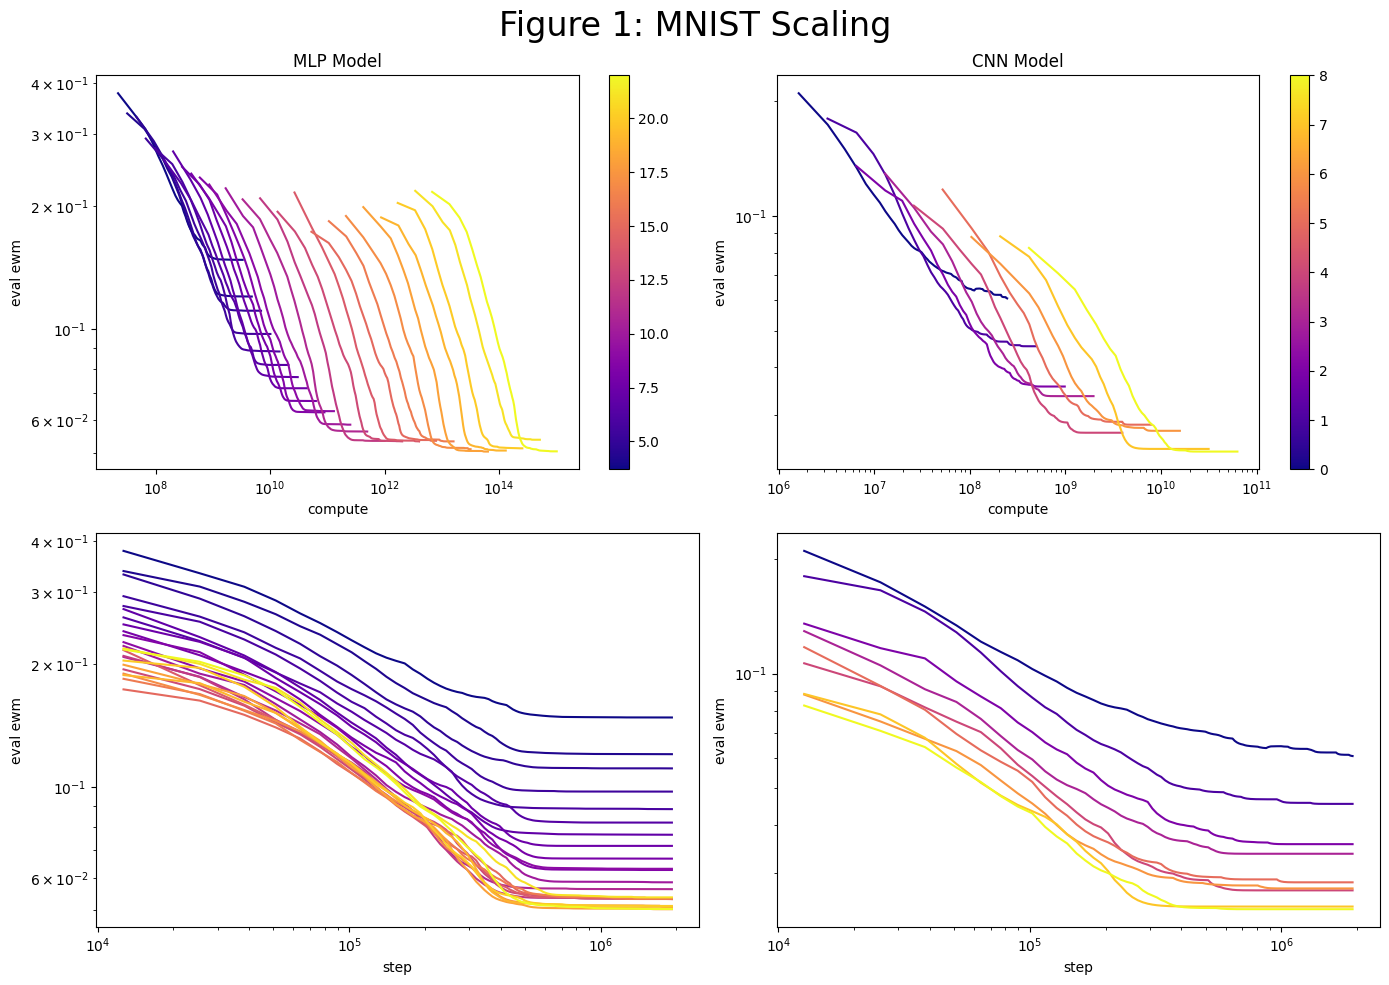

In [403]:
lin_cmap = sns.color_palette('plasma', len(lin_df['model_size'].unique())) 
CNN_cmap = sns.blend_palette(['black', "firebrick", 'orange', 'green' ], len(CNN_df['model_size'].unique())) 

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))
ax = ax.flatten()

sns.lineplot(data=lin_avg_df, x = 'compute', y='eval ewm', hue=np.log2(lin_avg_df['params']),  palette='plasma', ax=ax[0]).legend().remove()
sns.lineplot(data=CNN_avg_df, x = 'compute', y='eval ewm', hue=np.log2(CNN_avg_df['params']),  palette='plasma',  ax=ax[1]).legend().remove()
sns.lineplot(data=lin_avg_df, x = 'step', y='eval ewm', hue=np.log2(lin_avg_df['params']),  palette='plasma', ax=ax[2]).legend().remove()
sns.lineplot(data=CNN_avg_df, x = 'step', y='eval ewm', hue=np.log2(CNN_avg_df['params']),  palette='plasma',  ax=ax[3]).legend().remove()
for i in range(4):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')


norm = plt.Normalize(np.log2(CNN_avg_df['params'].min()), np.log2(CNN_avg_df['params'].max()))
CNN_sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
CNN_sm.set_array([])

plt.colorbar(CNN_sm,ax=ax[1])

norm = plt.Normalize(np.log2(lin_avg_df['params'].min()), np.log2(lin_avg_df['params'].max()))
lin_sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
lin_sm.set_array([])

plt.colorbar(lin_sm,ax=ax[0])

plt.suptitle("Figure 1: MNIST Scaling", fontsize = 24)
ax[0].title.set_text('MLP Model')
ax[1].title.set_text('CNN Model')
plt.tight_layout()

##### Observations
1. Predictably, as more compute is available ("compute" here is only relative), bigger models become optimal. 

2. Unlike in the Chinchilla and OpenAI results for transformer based LLM's, however, if you're training an MLP to recognize MNIST digits, training to convergence appears to be optimal, because of how quickly convergence happens. Indeed, all of the models were trained well past convergence. This isn't all too surprising, however: unlike in those papers, these models are training on repeated data. I suspect that with an infinite MNIST dataset we would see behavior more like what the OpenAI and DeepMind teems observed.

3. Much bigger models are substantially more data efficient than much smaller models for all training steps, except perhaps at the top of the model size range I tested. It's hard to tell whether the lower data efficiency of the larger MLP models is genuine or an artifact. 

4. If the underperformance of bigger MLP models is genuine, two plausible causes are a mistuned learning rate for larger models and overfitting. 

5. At around 10k parameters, the simple MLP architecture appears to hit its limit. Interestingly, however, if we had stopped training models at around 1k parameters, it would have appeared then that the architecture had hit its limit. What is happening at the 10k mark that gives the models the slight bump in performance that we can see above? It's possible that substantially bigger models could achieve lower eval loss figures. It might be an interesting project to see if there's a qualitative difference between the circuits in the 1-10k parameter models and the 10k + parameter models.

6. In addition to the scaling regime grossly changing past 1k parameter models, the compute efficient frontier is non-linear throughout. A similar curve in the compute efficient frontier can be seen in the Chinchilla paper. I'll estimate the parameters for the optimal model size and data size formulae using the "middle" part of the scaling curve. In the graphics below, I bound this region with two vertical lines.

7. The last two CNN models seem to be entering a new scaling regime. 


##### Scaling Formula Estimation

In [404]:
def fit_power_func(avg_scaling_df, compute_min, compute_max):
    compute_efficient_df = pd.DataFrame({'compute': [], 'params': [], 'step': []})
    compute_efficient_df['compute'] = [avg_scaling_df['compute'].unique()[i] for i in range(0, len(avg_scaling_df), 10)]

    efficient_models = []
    efficient_steps = []
    for compute in compute_efficient_df['compute']:
        efficient_models.append(avg_scaling_df[avg_scaling_df.loc[avg_scaling_df['compute'] <= compute]['eval_loss'].min() == avg_scaling_df.eval_loss]['params'].values.item())
        efficient_steps.append(avg_scaling_df[avg_scaling_df.loc[avg_scaling_df['compute'] <= compute]['eval_loss'].min() == avg_scaling_df.eval_loss].index[0][1])
    compute_efficient_df['params'] = efficient_models
    compute_efficient_df['step'] = efficient_steps

    compute_efficient_df['log compute'] = np.log10(compute_efficient_df.compute)
    compute_efficient_df['log params'] = np.log10(compute_efficient_df.params)
    compute_efficient_df['log step'] = np.log10(compute_efficient_df.step)

    partial_df = compute_efficient_df[compute_efficient_df.compute.between(compute_min, compute_max)]

    param_reg = LinearRegression().fit(partial_df['log compute'].values.reshape(-1, 1), partial_df['log params'].values)
    data_reg = LinearRegression().fit(partial_df['log compute'].values.reshape(-1, 1), partial_df['log step'].values)
    return compute_efficient_df, partial_df, param_reg, data_reg


In [405]:
lin_min = 1e9
lin_max = 2e11
lin_efficient_df, lin_partial_df, lin_param_reg, lin_data_reg = fit_power_func(lin_avg_df, lin_min, lin_max)

CNN_min = 1e7
CNN_max = 1e9
CNN_efficient_df, CNN_partial_df, CNN_param_reg, CNN_data_reg = fit_power_func(CNN_avg_df, CNN_min, CNN_max)

print('MLP Size Coeff:', lin_param_reg.coef_)
print('MLP Data Coeff:', lin_data_reg.coef_)
print('CNN Size Coeff:', CNN_param_reg.coef_)
print('CNN Data Coeff:', CNN_data_reg.coef_)

MLP Size Coeff: [0.84980657]
MLP Data Coeff: [0.09750803]
CNN Size Coeff: [0.62685544]
CNN Data Coeff: [0.35118701]


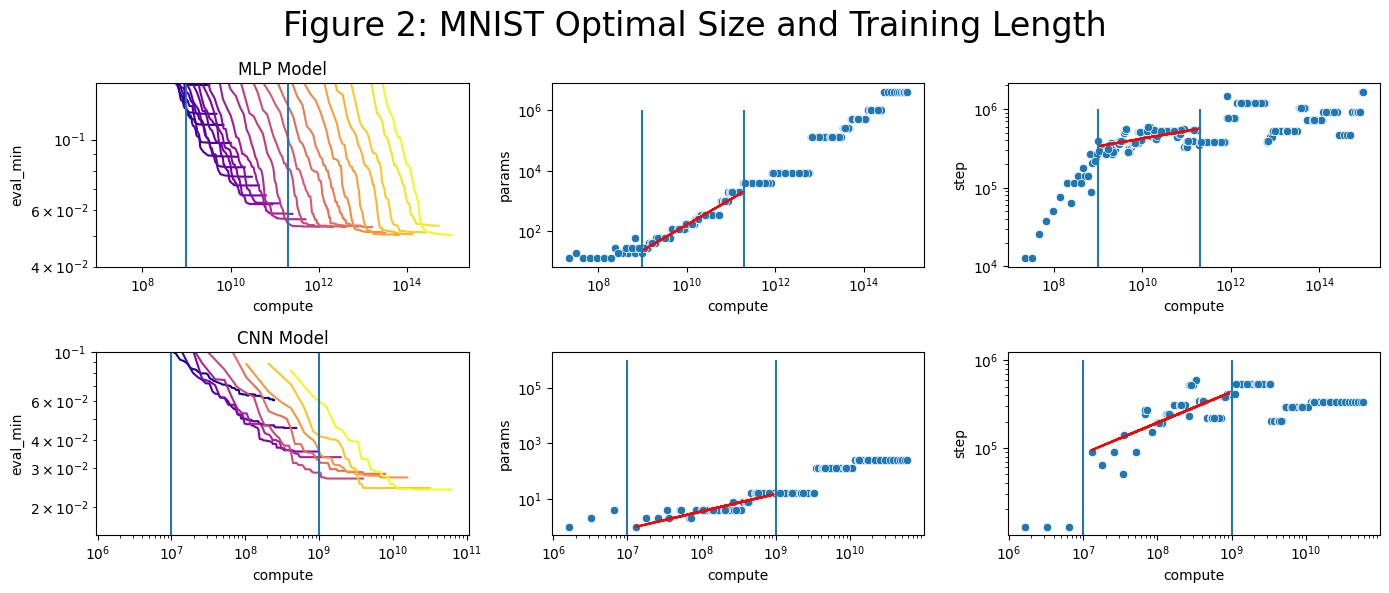

In [406]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 6))
ax = ax.flatten()

sns.lineplot(data=lin_avg_df, x = 'compute', y='eval_min', hue=np.log2(lin_avg_df['params']),  palette='plasma', ax=ax[0]).legend_.remove()

sns.scatterplot(data=lin_efficient_df, x = 'compute', y='params', ax=ax[1])
ax[1].plot(lin_partial_df['compute'], lin_partial_df['compute']**lin_param_reg.coef_ * 10**lin_param_reg.intercept_, color='r')

sns.scatterplot(data=lin_efficient_df, x = 'compute', y='step', ax=ax[2])
ax[2].plot(lin_partial_df['compute'], lin_partial_df['compute']**lin_data_reg.coef_ * 10**lin_data_reg.intercept_, color='r')

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].vlines(x=lin_min, ymin=0, ymax=1e6)
    ax[i].vlines(x=lin_max, ymin=0, ymax=1e6)

sns.lineplot(data=CNN_avg_df, x = 'compute', y='eval_min', hue=np.log2(CNN_avg_df['params']),  palette='plasma', ax=ax[3]).legend_.remove()

sns.scatterplot(data=CNN_efficient_df, x = 'compute', y='params', ax=ax[4])
ax[4].plot(CNN_partial_df['compute'], CNN_partial_df['compute']**CNN_param_reg.coef_ * 10**CNN_param_reg.intercept_, color='r')

sns.scatterplot(data=CNN_efficient_df, x = 'compute', y='step', ax=ax[5])
ax[5].plot(CNN_partial_df['compute'], CNN_partial_df['compute']**CNN_data_reg.coef_ * 10**CNN_data_reg.intercept_, color='r')

for i in range(3, 6):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].vlines(x=CNN_min, ymin=0, ymax=1e6)
    ax[i].vlines(x=CNN_max, ymin=0, ymax=1e6)
ax[0].set_ylim(4e-2, 1.5e-1)
ax[3].set_ylim(1.5e-2, 1e-1)


plt.legend([],[], frameon=False)
plt.suptitle("Figure 2: MNIST Optimal Size and Training Length", fontsize = 24)
ax[0].title.set_text('MLP Model')
ax[3].title.set_text('CNN Model')

plt.tight_layout()

### Scaling Formulae
The region bounded by the vertical lines is the region whose scaling properties I'm going to estimate. 

If we assume that the optimal model size and training length depend on power laws on compute, we get the following formulae:

##### MLP Model

$N_{opt} = \frac{C^{0.85}}{1895927}$,      $S_{opt} = 44667 \times C^{0.1}$

##### CNN Model

$N_{opt} = \frac{C^{0.67}}{71364}$,      $S_{opt} = 3239 \times C^{0.23}$

These results suggest that MLP MNIST scaling loads far more heavily on parameter count than on data. Both the Chinchilla and OpenAI papers report higher exponents for the optimal data size equation. Again, this is almost certainly because of the fact that I'm reusing the same 60,000 MNIST images to train these models. It's likely that the data size exponent would be higher if we had an infinite MNIST data set to sample from. 

CNN MNIST scaling loads less heavily on parameter count than the MLP regime, but the Chinchilla and OpenAI papers still report higher exponents for the optimal data size equation. Again, this is almost certainly because of the fact that I'm reusing the same 60,000 MNIST images to train these models. 

It would be interesting, however, to see exactly how much higher it would be. In the next section, I try to approximate this somewhat with EMNIST and elastic distortions.

# MLP Scaling on Augmented EMNIST Data

To better approximate a situation in which we had an infinite MNIST data set, I repeat the experiment above, but use augmented EMNIST data. EMNIST itself contains 240,000 training images similar to MNIST images, and I double the training size by randomly introducing elastic distortions. The effect of these distortions, to my eyes at least, is to create plausibly human-written variations of the EMNIST digit styles. I'd like to have been able to train for longer (I only train each model for 480,000 / batch size steps, whereas in the MNIST experiment I train each model for 1,920,000 / batch_size steps), but my computer takes a while to perform the elastic transformations on each batch, and the networks are more or less converging by the ends of their training runs anyway. 

All other training parameters are the same as those for the repeated MNIST experiment.

In [407]:
CNN_df = pd.read_csv('EMNIST_CNN.csv')
CNN_df['compute'] = CNN_df['params'] * CNN_df['step']
lin_df = pd.read_csv('EMNIST_linear.csv')


lin_avg_df = lin_df.groupby(['model_size', 'step']).mean()
CNN_avg_df = CNN_df.groupby(['model_size', 'step']).mean()


lin_avg_df['eval ewm'] = lin_avg_df.groupby('model_size')['eval_min'].transform(lambda x: x.ewm(com=1).mean()).values
CNN_avg_df['eval ewm'] = CNN_avg_df.groupby('model_size')['eval_min'].transform(lambda x: x.ewm(com=1).mean()).values


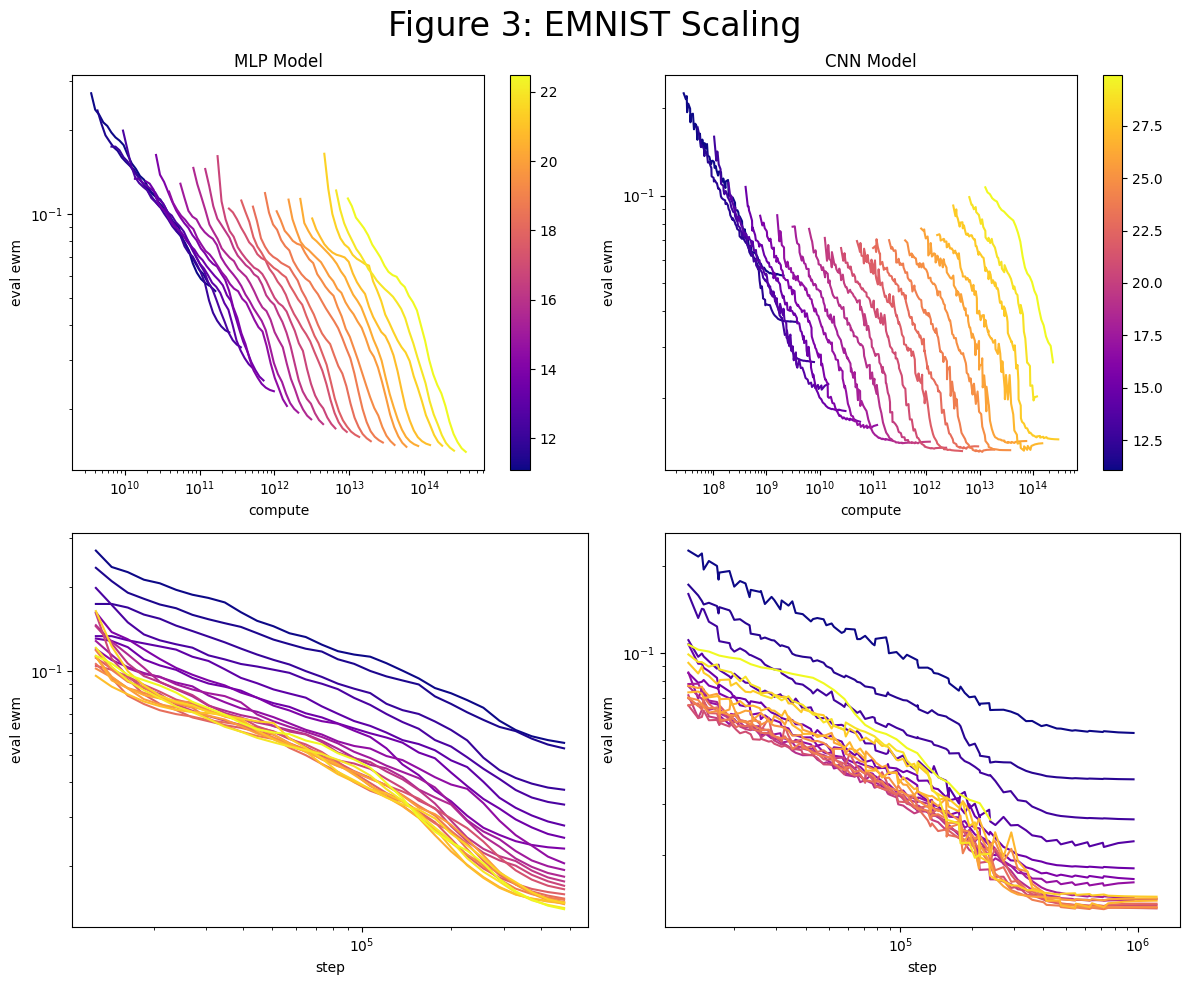

In [408]:
lin_cmap = sns.color_palette('plasma', len(lin_df['model_size'].unique())) 
CNN_cmap = sns.blend_palette(['black', "firebrick", 'orange', 'green' ], len(CNN_df['model_size'].unique())) 

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
ax = ax.flatten()

sns.lineplot(data=lin_avg_df, x = 'compute', y='eval ewm', hue=np.log2(lin_avg_df['params']),  palette='plasma', ax=ax[0]).legend().remove()
sns.lineplot(data=CNN_avg_df, x = 'compute', y='eval ewm', hue=np.log2(CNN_avg_df['params']),  palette='plasma',  ax=ax[1]).legend().remove()
sns.lineplot(data=lin_avg_df, x = 'step', y='eval ewm', hue=np.log2(lin_avg_df['params']),  palette='plasma', ax=ax[2]).legend().remove()
sns.lineplot(data=CNN_avg_df, x = 'step', y='eval ewm', hue=np.log2(CNN_avg_df['params']),  palette='plasma',  ax=ax[3]).legend().remove()
for i in range(4):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')


norm = plt.Normalize(np.log2(CNN_avg_df['params'].min()), np.log2(CNN_avg_df['params'].max()))
CNN_sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
CNN_sm.set_array([])

plt.colorbar(CNN_sm,ax=ax[1])

norm = plt.Normalize(np.log2(lin_avg_df['params'].min()), np.log2(lin_avg_df['params'].max()))
lin_sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
lin_sm.set_array([])

plt.colorbar(lin_sm,ax=ax[0])

plt.suptitle("Figure 3: EMNIST Scaling", fontsize = 24)
ax[0].title.set_text('MLP Model')
ax[1].title.set_text('CNN Model')
plt.tight_layout()

In [409]:
lin_min = 1e12
lin_max = 2e13
lin_efficient_df, lin_partial_df, lin_param_reg, lin_data_reg = fit_power_func(lin_avg_df, lin_min, lin_max)

CNN_min = 1e11
CNN_max = 1e13
CNN_efficient_df, CNN_partial_df, CNN_param_reg, CNN_data_reg = fit_power_func(CNN_avg_df, CNN_min, CNN_max)

print('MLP Size Coeff:', lin_param_reg.coef_)
print('MLP Data Coeff:', lin_data_reg.coef_)
print('CNN Size Coeff:', CNN_param_reg.coef_)
print('CNN Data Coeff:', CNN_data_reg.coef_)

MLP Size Coeff: [1.04511108]
MLP Data Coeff: [-0.01353775]
CNN Size Coeff: [0.77416286]
CNN Data Coeff: [0.15859723]


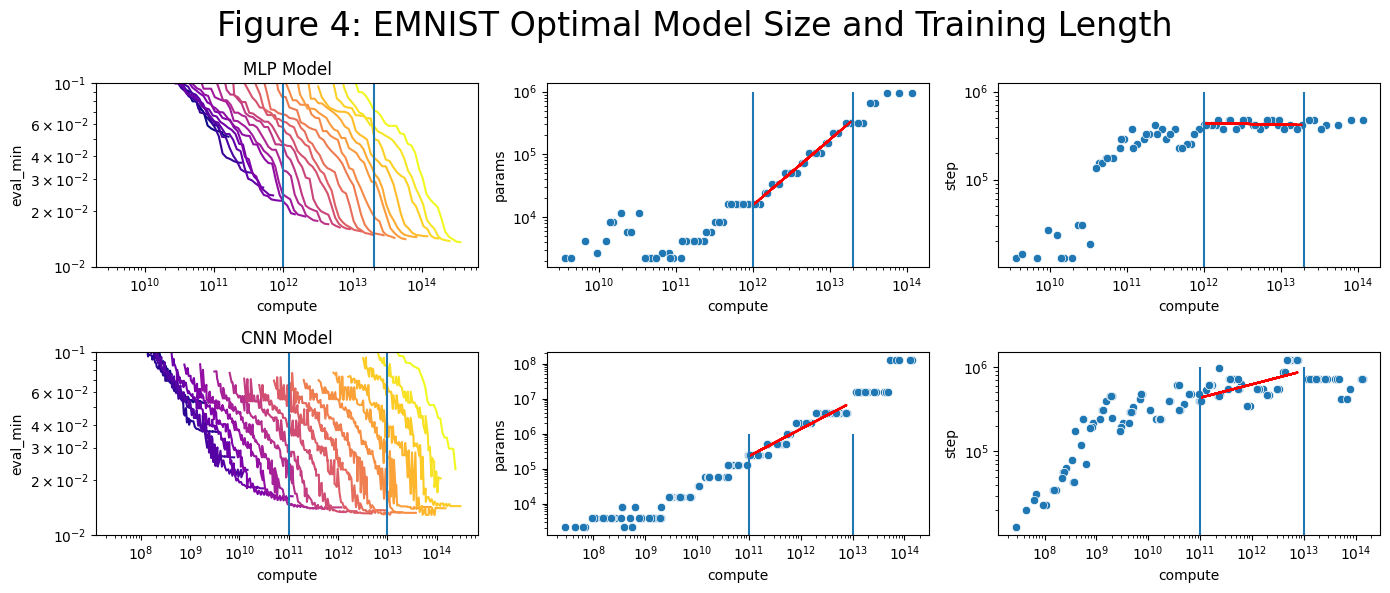

In [410]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 6))
ax = ax.flatten()

sns.lineplot(data=lin_avg_df, x = 'compute', y='eval_min', hue=np.log2(lin_avg_df['params']),  palette='plasma', ax=ax[0]).legend_.remove()

sns.scatterplot(data=lin_efficient_df, x = 'compute', y='params', ax=ax[1])
ax[1].plot(lin_partial_df['compute'], lin_partial_df['compute']**lin_param_reg.coef_ * 10**lin_param_reg.intercept_, color='r')

sns.scatterplot(data=lin_efficient_df, x = 'compute', y='step', ax=ax[2])
ax[2].plot(lin_partial_df['compute'], lin_partial_df['compute']**lin_data_reg.coef_ * 10**lin_data_reg.intercept_, color='r')

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].vlines(x=lin_min, ymin=0, ymax=1e6)
    ax[i].vlines(x=lin_max, ymin=0, ymax=1e6)

sns.lineplot(data=CNN_avg_df, x = 'compute', y='eval_min', hue=np.log2(CNN_avg_df['params']),  palette='plasma', ax=ax[3]).legend_.remove()

sns.scatterplot(data=CNN_efficient_df, x = 'compute', y='params', ax=ax[4])
ax[4].plot(CNN_partial_df['compute'], CNN_partial_df['compute']**CNN_param_reg.coef_ * 10**CNN_param_reg.intercept_, color='r')

sns.scatterplot(data=CNN_efficient_df, x = 'compute', y='step', ax=ax[5])
ax[5].plot(CNN_partial_df['compute'], CNN_partial_df['compute']**CNN_data_reg.coef_ * 10**CNN_data_reg.intercept_, color='r')

for i in range(3, 6):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].vlines(x=CNN_min, ymin=0, ymax=1e6)
    ax[i].vlines(x=CNN_max, ymin=0, ymax=1e6)

ax[0].set_ylim(1e-2, 1e-1)
ax[3].set_ylim(1e-2, 1e-1)

plt.legend([],[], frameon=False)
plt.suptitle('Figure 4: EMNIST Optimal Model Size and Training Length', fontsize=24)
ax[0].title.set_text('MLP Model')
ax[3].title.set_text('CNN Model')

plt.tight_layout()

### Scaling Formulae
The region bounded by the vertical lines is the region whose scaling properties I'm going to estimate. 

If we assume that the optimal model size and training length depend on power laws on compute, we get the following formulae:

##### CNN Model

$N_{opt} \propto C^{.77}$,      $D_{opt} \propto C^{0.16}$

I consider this a failure for the MLP model. I don't report the MLP model's scaling paramters because, as can be seen in Figure 4 above, the MLP model is data limited in the region where there seems to be a consistent scaling regime. 

As for the CNN model, we see similar scaling paramters as we saw in the MNIST experiment. This suggests either that digit recognition is not a data loading task or that the elastic distortions don't make "new" data very valuable for the models.